# 1. Introduction

In this notebook, I will use the below dataset for Horse Races in Hong Kong to predict the final position of a horse in a race.

https://www.kaggle.com/datasets/gdaley/hkracing?select=runs.csv


In [1]:
# Necessary imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math

# Set Random Seed
np.random.seed(42)

# 2. Preparing the Data

## 2.1 Importing the Data

I import the two (2) data files provided, and merge them on the race_id index column.

In [2]:
# Import files into DataFrames
races = pd.read_csv('races.csv')
runs = pd.read_csv('runs.csv')

# Merge on race_id index
merged = pd.merge(races, runs, on=["race_id"], how="inner")

# Lets take a peek
merged.head(5)

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,...,time2_y,time3_y,time4_y,time5_y,time6_y,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,21.59,23.86,24.62,NaN,NaN,83.92,9.7,3.7,118,2
1,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,21.99,23.30,23.70,NaN,NaN,83.56,16.0,4.9,164,57
2,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,21.59,23.90,24.22,NaN,NaN,83.40,3.5,1.5,137,18
3,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,21.83,23.70,24.00,NaN,NaN,83.62,39.0,11.0,80,59
4,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,21.75,23.22,23.50,NaN,NaN,83.24,50.0,14.0,9,154


## 2.2 Initial Feature Selection

I then select features that are easily-interpreted and/or processed to be used in my model.

In [3]:
# Select features and output column (result - this is the horse's final position in the race)
selected = merged[['venue','surface','distance',
                   'going','race_class','result',
                   'horse_age','horse_country','horse_type',
                   'horse_rating','declared_weight','actual_weight',
                   'trainer_id','jockey_id']]

## 2.3 Handling Missing Values

I take a count of how many rows have missing values. As they account for such a small subset of my data, I remove them.

In [4]:
# Select all rows with empty values
empty_rows = selected[selected.isna().any(axis=1)]

# Report on findings
print("There are",len(empty_rows),"rows with empty values")
print("This accounts for", len(empty_rows)/len(selected) * 100,"% of the dataset.")

There are 2 rows with empty values
This accounts for 0.0025174015381323397 % of the dataset.


In [5]:
# Remove rows with empty values
cleaned = selected.copy()
cleaned.dropna(inplace=True)

## 2.4 Converting Categorical Variables

There are many categorical columns, which I convert to boolean.

In [6]:
# Add new columns with boolean values for categorical features

venue_encoded = pd.get_dummies(cleaned['venue'], prefix='venue') # Get new columns to add
cleaned = pd.concat([cleaned, venue_encoded], axis=1) # Concatenate onto existing DataFrame
cleaned.drop(columns=['venue'], inplace=True) # Drop the original column

surface_encoded = pd.get_dummies(cleaned['surface'])
surface_encoded.columns = ['Dirt', 'Turf']
cleaned = pd.concat([cleaned, surface_encoded], axis=1)
cleaned.drop(columns=['surface'], inplace=True)

going_encoded = pd.get_dummies(cleaned['going'], prefix='going')
cleaned = pd.concat([cleaned, going_encoded], axis=1)
cleaned.drop(columns=['going'], inplace=True)

horse_country_encoded = pd.get_dummies(cleaned['horse_country'], prefix='horse_country')
cleaned = pd.concat([cleaned, horse_country_encoded], axis=1)
cleaned.drop(columns=['horse_country'], inplace=True)

horse_type_encoded = pd.get_dummies(cleaned['horse_type'], prefix='horse_type')
cleaned = pd.concat([cleaned, horse_type_encoded], axis=1)
cleaned.drop(columns=['horse_type'], inplace=True)

cleaned.head(5) # Let's take a peak!

,distance,race_class,result,horse_age,horse_rating,declared_weight,actual_weight,trainer_id,jockey_id,venue_HV,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1400,5,10,3,60,1020.0,133,118,2,False,...,False,False,False,False,True,False,False,False,False,False
1,1400,5,8,3,60,980.0,133,164,57,False,...,False,False,False,False,True,False,False,False,False,False
2,1400,5,7,3,60,1082.0,132,137,18,False,...,False,False,False,False,True,False,False,False,False,False
3,1400,5,9,3,60,1118.0,127,80,59,False,...,False,False,False,False,True,False,False,False,False,False
4,1400,5,6,3,60,972.0,131,9,154,False,...,False,False,False,False,True,False,False,False,False,False


## 2.5 Splitting into Training and Test Sets

I take a (roughly) 80/20 training/test split of the data.

In [7]:
# Split the dataset into features and target variable
X = cleaned.drop(['result'], axis=1)  # Features
y = cleaned['result']                 # Target variable

# We want roughly 80% training, 20% test
train_cap = int(len(X)*0.8)

X_train = X.iloc[:train_cap]
X_test = X.iloc[train_cap:]
y_train = y.iloc[:train_cap]
y_test = y.iloc[train_cap:]

# 3. Model Selection

## 3.1 Model Selection Metrics

With this being a supervised regression problem, I choose regression metrics including:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- R-squared (R2)

to complete my model selection.

## 3.2 Potential Models

I will be deciding between Ensemble methods for this ML problem - specifically **Gradient Boosting** and **Random Forests**. These models are a good choice for this machine learning problem for a number of reasons:
- *Ensemble Methods* - The aggregation of models in ensemble methods help to reduce overfitting, which improves generalization.
- *Non-Linearity* - This dataset has many features, which may or may not have a linear relationship with the outcome. Ensemble methods capture non-linear relationships well.
- *Tuning* - There are many hyperparameters to tune, and provide methods for ranking, and interpreting feature importance. This means I will not only be able to predict if a horse's finishing position in a race, but also what factors are most important in predicting the win.

## 3.3 Hyperparameter Tuning

Both methods have an adequate number of hyperparameters to tune, which I will complete using BayesCV. For both models, I will tune the hyperparameters based on minimizing the Mean Absolute Error, and select a final model (and corresponding tuned parameters) using the other calculated regression metrics on the set.

In [8]:
#Performance metric calculations

# Mean Squared Error
def get_mse(y_true, y_pred):
    n = len(y_true)
    squared_errors = [(true - pred) ** 2 for true, pred in zip(y_true, y_pred)]
    mse = sum(squared_errors) / n
    return mse

# Root Mean Squared Error
def get_rmse(y_true, y_pred):
    mse = get_mse(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

# Mean Absolute Error
def get_mae(y_true, y_pred):
    n = len(y_true)
    absolute_errors = [abs(true - pred) for true, pred in zip(y_true, y_pred)]
    mae = sum(absolute_errors) / n
    return mae

# R-Squared
def get_r2(y_true, y_pred):
    n = len(y_true)
    mean_y_true = sum(y_true) / n
    total_sum_of_squares = sum((true - mean_y_true) ** 2 for true in y_true)
    residual_sum_of_squares = sum((true - pred) ** 2 for true, pred in zip(y_true, y_pred))
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2

In [9]:
# Helper function for optimizing a model for a given search_space
def optimize_model(model, search_spaces):
    # Perform optimization
    opt = BayesSearchCV(
                model,
                search_spaces,
                n_iter=20,                             # Iterations for the optimization
                scoring='neg_mean_absolute_error',     # Evaluate on chosen metric
                cv=5,                                  # Cross-validation folds (set to default of 5)
                n_jobs=-1                              # Set to use all available cores
            )
    return opt

# Helper function for calculating performance metrics and recording them in a provided dataframe
def fit_model_and_record(opt, results, tag, X_train, y_train, X_test, y_test):
    opt.fit(X_train, y_train)
    y_pred = opt.predict(X_test)
    
    mse = get_mse(y_test, y_pred)
    rmse = get_rmse(y_test, y_pred)
    mae = get_mae(y_test, y_pred)
    r2 = get_r2(y_test, y_pred)

    new_row = {
        'tag': tag,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    # Concatenate the new row to the results
    results = pd.concat([results, pd.DataFrame(data=[new_row])], ignore_index=True)
    return results

In [10]:
# Define search spaces for hyperparameters

# Gradient Boosting
gbr_search_spaces = {
    'n_estimators': (50, 500), # Number of trees in the forest
    'learning_rate': (0.01, 1.0), # Step-size shrinkage
    'max_depth': (3, 10), # Controls tree depth
    'min_samples_split': (2, 20), # Minimum number of samples required to split an internal node
}

# Random Forest
rf_search_spaces = {
    'n_estimators': (50, 500), # Number of trees in the forest
    'max_depth': (3, 10), # Controls tree depth
    'min_samples_split': (2, 10), # Minimum number of samples required to split an internal node
    'max_features': (0.1, 1.0)
}

# Names of the models, for use in documenting and keying dictionary
modelNames = ['GBR','RandomForest']

# Initialize dictionary to store optimized model params
myDict = {}

# Initialize dataframe containing the name of the model
# And corresponding measurement metrics
results = pd.DataFrame(columns=['tag', 'mse', 'rmse', 'mae', 'r2'])

# Loop through potential models
for modelName in modelNames:
    
    # Define search space and classifier based on model name
    if modelName == "GBR":
        search_spaces = gbr_search_spaces
        model = GradientBoostingRegressor()
    if modelName == "RandomForest":
        search_spaces = rf_search_spaces
        model = RandomForestClassifier()

    # Get optimized model
    opt = optimize_model(model, search_spaces)
    
    # Fit optimized model and calculate scores on the test set
    results = fit_model_and_record(opt, results, modelName, X_train, y_train, X_test, y_test)

    # Store the model for later use
    myDict[modelName] = opt.best_params_
            
print(results)  
print("") # For readability
print(myDict)

            tag        mse      rmse       mae        r2
0           GBR  13.245066  3.639377  3.064864  0.047022
1  RandomForest  23.684813  4.866705  3.920448 -0.704113

{'GBR': OrderedDict([('learning_rate', 0.24488295756386091), ('max_depth', 3), ('min_samples_split', 20), ('n_estimators', 500)]), 'RandomForest': OrderedDict([('max_depth', 3), ('max_features', 0.3154320080856365), ('min_samples_split', 3), ('n_estimators', 467)])}


## 3.4 Results

The results of the above at the time of running are recorded below for readability 

|           Model       |      mse      |     rmse     |     mae      |     r2       |
|----------------------|---------------|--------------|--------------|--------------|
|           GBR        |   13.245066   |   3.639377   |   3.064864   |   0.047022   |
|    RandomForest      |   23.684813   |   4.866705   |   3.920448   |  -0.704113   |



For MSE, RMSE, and MAE, lower is better, and I note that the optimized model for GBR has a lower value for all three than Random Forest. For R-Squared, we want the score closest to 1. Both models have very low R2, but GBR's is slightly higher. Based on this evaluation, I choose the GBR model.

In [15]:
# Below are the parameters of the otimized GBR model
params = {
    'n_estimators': 50,
    'learning_rate': 0.24488295756386091,
    'max_depth': 3,
    'min_samples_split': 20,
}

# 4 Feature Selection

Now that we have selected our model, we can further examine its performance with feature selection. 

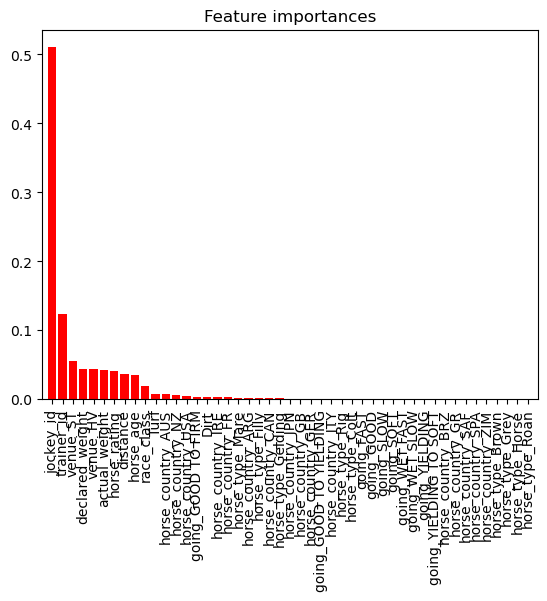

In [16]:
# Select model and fit
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

# Get feature importance and sort in descending order
feature_importances = model.feature_importances_

# Collect the names of the features
feature_names = X_train.columns.tolist()

# Pair feature names with their importances
feature_importance_pairs = [(feature, importance) for feature, importance in zip(feature_names, feature_importances)]

# Sort feature importances by importance
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feature_importance_pairs)), [importance for _, importance in feature_importance_pairs], color="r", align="center")
plt.xticks(range(len(feature_importance_pairs)), [feature for feature, _ in feature_importance_pairs], rotation='vertical')
plt.xlim([-1, len(feature_importance_pairs)])
plt.show()

From the feature importance chart above, I see many of the features have been ranked as having very little importance on the model, with a large drop after "horse age". Based on this, I wonder if my model's accuracy can be further improved by removing some of the non-important features from the training and test set.

I test this out by experimenting with removing features below different boundaries of importance, re-optimizing my model, and recording the resulting performance metrics.

In [17]:
# Save metrics prior to feature selection
feature_results = pd.DataFrame(columns=['tag', 'mse', 'rmse', 'mae', 'r2'])

model = GradientBoostingRegressor(**params)
fit_model_and_record(model, feature_results, 0, X_train, y_train, X_test, y_test)

# Loop through different importance boundaries
for boundary in [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]:
    selected_features = [feature for feature, importance in feature_importance_pairs if importance > boundary]
    
    # Filter training and testing data to include only selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Re-Optimize the model
    model = GradientBoostingRegressor(**params)
    
    #Record the results
    feature_results = fit_model_and_record(model, feature_results, boundary, X_train_selected, y_train, X_test_selected, y_test)

print(feature_results)

     tag        mse      rmse       mae        r2
0  0.005  12.937924  3.596933  3.066874  0.069121
1  0.010  13.000286  3.605591  3.074856  0.064634
2  0.020  13.033621  3.610211  3.078725  0.062236
3  0.030  13.033621  3.610211  3.078725  0.062236
4  0.040  13.107436  3.620419  3.082996  0.056925
5  0.050  12.994956  3.604852  3.086810  0.065018


This gives us the below results.

|   Importance Boundary   |      mse      |     rmse     |     mae      |     r2       |
|---------|---------------|--------------|--------------|--------------|
|  0.005  |   12.937924   |   3.596933   |   3.066874   |   0.069121   |
|  0.010  |   13.000286   |   3.605591   |   3.074856   |   0.064634   |
|  0.020  |   13.033621   |   3.610211   |   3.078725   |   0.062236   |
|  0.030  |   13.033621   |   3.610211   |   3.078725   |   0.062236   |
|  0.040  |   13.107436   |   3.620419   |   3.082996   |   0.056925   |
|  0.050  |   12.994956   |   3.604852   |   3.086810   |   0.065018   |


Based on the above, I decide not to remove any features. As my MAE increases as more features are removed, and r2 decreases.
